In [1]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

In [2]:
# Connect to the database
db_path = '/workspaces/ESG_Analytics/ESG_Database.db'
conn = sqlite3.connect(db_path)

Below query is finding companies that have data in all three tables (Bloomberg ESG, ESG Performance, and News Sentiment) for at least one common year

In [3]:
# Find companies with data in all tables
query_complete_companies = """
WITH common_years AS (
    SELECT b.year
    FROM (SELECT DISTINCT year FROM BLOOMBERG_ESG) b
    JOIN (SELECT DISTINCT year FROM ESG_PERFORMANCE) p ON b.year = p.year
    JOIN (SELECT DISTINCT year FROM NEWS_SENTIMENT) n ON b.year = n.year
)

SELECT DISTINCT c.id, c.company_name
FROM COMPANIES c
JOIN (
    SELECT b.id, b.year
    FROM BLOOMBERG_ESG b
    JOIN common_years y ON b.year = y.year
    
    INTERSECT
    
    SELECT e.id, e.year
    FROM ESG_PERFORMANCE e
    JOIN common_years y ON e.year = y.year
    
    INTERSECT
    
    SELECT n.id, n.year
    FROM NEWS_SENTIMENT n
    JOIN common_years y ON n.year = y.year
) data ON c.id = data.id
"""

complete_companies = pd.read_sql_query(query_complete_companies, conn)
company_ids = tuple(complete_companies['id'].tolist())
print(f"Found {len(complete_companies)} companies with complete data")

Found 1427 companies with complete data


The below SQL query is retrieving a comprehensive dataset for your ESG decoupling analysis. It combines information from all four tables in our database, filtering for only the companies I  identified as having complete data.

In [4]:
# Load the full dataset for these companies
query_main = f"""
SELECT 
    c.id, c.company_name, c.industry_name, 
    c.financial_industry, c.east, c.west, c.mid,
    c.hightech_1, c.hightech_2, c.pollute_1, c.pollute_2, c.pollute_3,
    b.year, b.bloomberg_esg, b.bloomberg_e, b.bloomberg_s, b.bloomberg_g,
    e.comprehensive_score, e.e_score, e.s_score, e.g_score, e.overall_rating,
    n.positive_news_all, n.negative_news_all, n.neutral_news_all, 
    n.news_title_count, n.news_content_count
FROM COMPANIES c
JOIN BLOOMBERG_ESG b ON c.id = b.id
JOIN ESG_PERFORMANCE e ON c.id = e.id AND b.year = e.year
JOIN NEWS_SENTIMENT n ON c.id = n.id AND b.year = n.year
WHERE c.id IN {company_ids}
ORDER BY c.id, b.year
"""

data = pd.read_sql_query(query_main, conn)

In [5]:
# Convert columns to appropriate types and handle missing values
numeric_cols = ['financial_industry', 'east', 'west', 'mid', 
                'hightech_1', 'hightech_2', 'pollute_1', 'pollute_2', 'pollute_3',
                'bloomberg_esg', 'bloomberg_e', 'bloomberg_s', 'bloomberg_g',
                'comprehensive_score', 'e_score', 's_score', 'g_score',
                'positive_news_all', 'negative_news_all', 'neutral_news_all',
                'news_title_count', 'news_content_count']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing values
data = data.fillna(0)

##### Sentiment Score: Quantifying Media Perception

The sentiment score normalizes media coverage on a scale from -1 to +1:

Numerator: Net sentiment (positive articles minus negative articles)  
Denominator: Total article count plus 1 (preventing division by zero)  

+1 = entirely positive coverage  
0 = neutral overall  
-1 = entirely negative coverage  

This standardized scale enables comparison across companies regardless of their size or media visibility.  

#### ESG Decoupling Metrics: Measuring Rating Disparities

These calculations quantify the percentage difference between Bloomberg's ESG scores and independent ratings:

Numerator: Absolute difference between rating systems  
Denominator: Independent score value plus 1 (preventing division by zero)  
Multiplication by 100: Converts to percentage format  

0% = perfect alignment between rating systems  
Higher percentages = greater discrepancy  

Similar formulas apply to the environmental (E), social (S), and governance (G) component scores.  

#### News-ESG Decoupling: Identifying Media-Rating Disconnects

This metric reveals discrepancies between news sentiment and Bloomberg ESG scores:  

Bloomberg scores are first normalized to 0-1 scale for direct comparison  
The absolute difference captures the magnitude of disconnect  

Low values indicate alignment between media perception and ESG ratings  
High values suggest potential misrepresentation or information asymmetry  

#### Combined Decoupling Score: Comprehensive Assessment

The total decoupling score combines both dimensions through a weighted average:  

70% weight given to rating system discrepancies  
30% weight given to news-rating disconnects (scaled to percentage)  

Higher scores flag companies with potential ESG misrepresentation  
Considers both official rating disparities and media perception gaps  


This combined metric serves as a powerful indicator for identifying potential greenwashing and ESG credibility issues.  

In [8]:
# Calculate key metrics
# Sentiment score (-1 to 1 scale)
data['sentiment_score'] = (data['positive_news_all'] - data['negative_news_all']) / \
                           (data['positive_news_all'] + data['negative_news_all'] + data['neutral_news_all'] + 1)

# ESG decoupling metrics (percentage difference)
data['esg_decoupling'] = abs(data['bloomberg_esg'] - data['comprehensive_score']) / \
                           (data['comprehensive_score'] + 1) * 100
data['e_decoupling'] = abs(data['bloomberg_e'] - data['e_score']) / \
                        (data['e_score'] + 1) * 100
data['s_decoupling'] = abs(data['bloomberg_s'] - data['s_score']) / \
                        (data['s_score'] + 1) * 100
data['g_decoupling'] = abs(data['bloomberg_g'] - data['g_score']) / \
                        (data['g_score'] + 1) * 100

# Normalized decoupling for sentiment comparison (0-1 scale)
data['news_decoupling'] = abs(data['sentiment_score'] - data['bloomberg_esg']/100)

# Create combined decoupling score
data['total_decoupling'] = (0.7 * data['esg_decoupling'] + 0.3 * data['news_decoupling'] * 100)

In [9]:
# Basic summary
print(f"Dataset shape: {data.shape}")
print("\nData summary:")
print(data[['esg_decoupling', 'total_decoupling', 'sentiment_score']].describe())

Dataset shape: (13692, 34)

Data summary:
       esg_decoupling  total_decoupling  sentiment_score
count    13692.000000      13692.000000     13692.000000
mean        60.718752         48.759001         0.157170
std         12.676648          9.185952         0.220002
min          6.138220          8.875943        -0.909091
25%         54.111630         43.023282         0.024390
50%         61.645932         48.886630         0.176471
75%         70.221044         54.907914         0.309032
max         89.802663         81.065915         0.822222


### ESG Decoupling Analysis - Step 1: Relationship Between Rating

Analyzing relationship between Bloomberg ESG scores and independent ratings

#### Correlation Analysis: Measuring ESG Rating Alignment
This section quantifies the relationship between Bloomberg ESG ratings and independent assessments through Pearson correlation analysis. This statistical approach measures the strength and significance of rating alignment across all ESG dimensions.

The code calculates correlation coefficients (r) for the overall ESG scores and each individual component. These r-values range from -1 to 1, where:

Values close to 1 indicate strong positive alignment between rating systems  
Values close to 0 indicate weak or no linear relationship  
Values close to -1 would suggest inverse relationships (which would be highly unexpected in this context)

In [10]:
# 1.1 Basic correlation analysis
from scipy import stats

# Calculate correlations for overall ESG and component scores
correlations = {
    'Overall ESG': stats.pearsonr(data['bloomberg_esg'], data['comprehensive_score']),
    'Environmental': stats.pearsonr(data['bloomberg_e'], data['e_score']),
    'Social': stats.pearsonr(data['bloomberg_s'], data['s_score']),
    'Governance': stats.pearsonr(data['bloomberg_g'], data['g_score'])
}

# Print correlation results
print("\nCorrelation between Bloomberg and Independent Ratings:")
for component, (r, p) in correlations.items():
    print(f"{component}: r = {r:.3f}, p-value = {p}")


Correlation between Bloomberg and Independent Ratings:
Overall ESG: r = 0.185, p-value = 3.3539970564061486e-106
Environmental: r = 0.252, p-value = 1.7466114890875373e-197
Social: r = 0.235, p-value = 1.8162628758424036e-171
Governance: r = -0.104, p-value = 3.1063830179746546e-34


#### Visualizing the Relationship Between ESG Rating Systems
This section creates a comprehensive visual comparison between Bloomberg ESG ratings and independent assessments across all major ESG components. The 2×2 grid of scatter plots provides immediate visual insight into the consistency between these rating systems.

Each scatter plot reveals important patterns in how these rating systems align. Points falling along a diagonal line from bottom-left to top-right would indicate perfect agreement between rating systems. Deviations from this line represent inconsistencies in how companies are evaluated.
The correlation coefficient (r) displayed in each title quantifies the strength of the relationship. Values closer to 1.0 indicate stronger alignment between Bloomberg and independent ratings, while lower values suggest more significant decoupling.

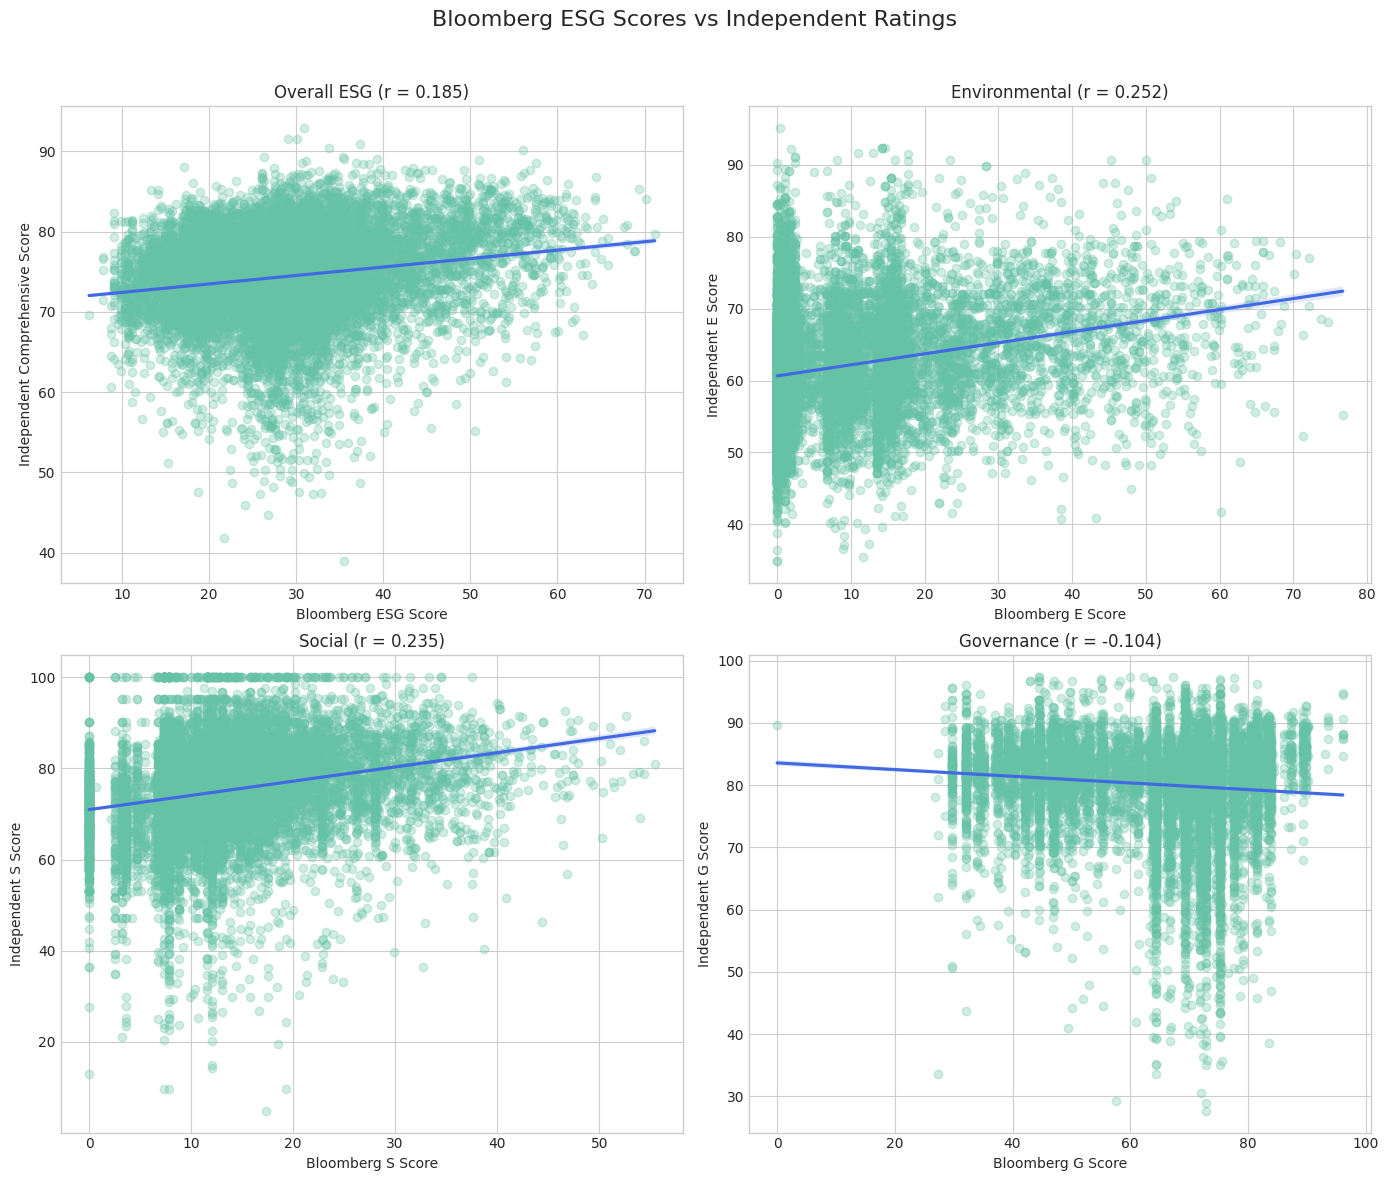

In [11]:
# 1.2 Visualize the relationships
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Bloomberg ESG Scores vs Independent Ratings', fontsize=16)

# Overall ESG scores
sns.regplot(x='bloomberg_esg', y='comprehensive_score', data=data, ax=axes[0, 0], line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3})
axes[0, 0].set_title(f'Overall ESG (r = {correlations["Overall ESG"][0]:.3f})')
axes[0, 0].set_xlabel('Bloomberg ESG Score')
axes[0, 0].set_ylabel('Independent Comprehensive Score')

# Environmental scores
sns.regplot(x='bloomberg_e', y='e_score', data=data, ax=axes[0, 1],line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3})
axes[0, 1].set_title(f'Environmental (r = {correlations["Environmental"][0]:.3f})')
axes[0, 1].set_xlabel('Bloomberg E Score')
axes[0, 1].set_ylabel('Independent E Score')

# Social scores
sns.regplot(x='bloomberg_s', y='s_score', data=data, ax=axes[1, 0],line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3})
axes[1, 0].set_title(f'Social (r = {correlations["Social"][0]:.3f})')
axes[1, 0].set_xlabel('Bloomberg S Score')
axes[1, 0].set_ylabel('Independent S Score')

# Governance scores
sns.regplot(x='bloomberg_g', y='g_score', data=data, ax=axes[1, 1],line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3})
axes[1, 1].set_title(f'Governance (r = {correlations["Governance"][0]:.3f})')
axes[1, 1].set_xlabel('Bloomberg G Score')
axes[1, 1].set_ylabel('Independent G Score')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('bloomberg_vs_independent.png')
plt.show()

#### Industry-Level ESG Decoupling Analysis
This section examines how ESG decoupling patterns vary across different industry sectors, revealing whether rating inconsistencies are concentrated in specific industries or distributed more broadly across the market.

The code aggregates our four decoupling metrics (overall ESG, environmental, social, and governance) by industry, calculating both the mean values and company counts. To ensure statistical reliability, we filter out industries with fewer than three companies, focusing our analysis on sectors with sufficient representation in the dataset.
The results are then sorted in descending order by average ESG decoupling score, allowing us to identify the industries where Bloomberg ratings and independent assessments diverge most significantly.

The horizontal bar chart visualization provides an immediate visual ranking of industries by their average decoupling scores. This graphical representation makes it easy to identify sectors where ESG rating inconsistencies are most pronounced, potentially indicating areas where existing rating methodologies may be less effective or where industry-specific ESG factors might be weighted differently by various rating providers.


ESG Decoupling by Industry (Top 5):
                                        industry_name esg_decoupling        \
                                                                mean count   
32                           Other service industries      70.101531    13   
43                               Residential services      68.215184    14   
25                       News and publishing industry      67.789005    59   
3   Agriculture, forestry, animal husbandry and fi...      67.364856    26   
69                                   leasing industry      67.084715    13   

   e_decoupling       s_decoupling       g_decoupling        
           mean count         mean count         mean count  
32    97.664081    13    90.641065    13    25.409040    13  
43    97.274460    14    90.373706    14    26.706847    14  
25    96.235158    59    85.201356    59    29.301178    59  
3     95.333598    26    86.754153    26    24.509341    26  
69    94.830784    13    90.364409    13    

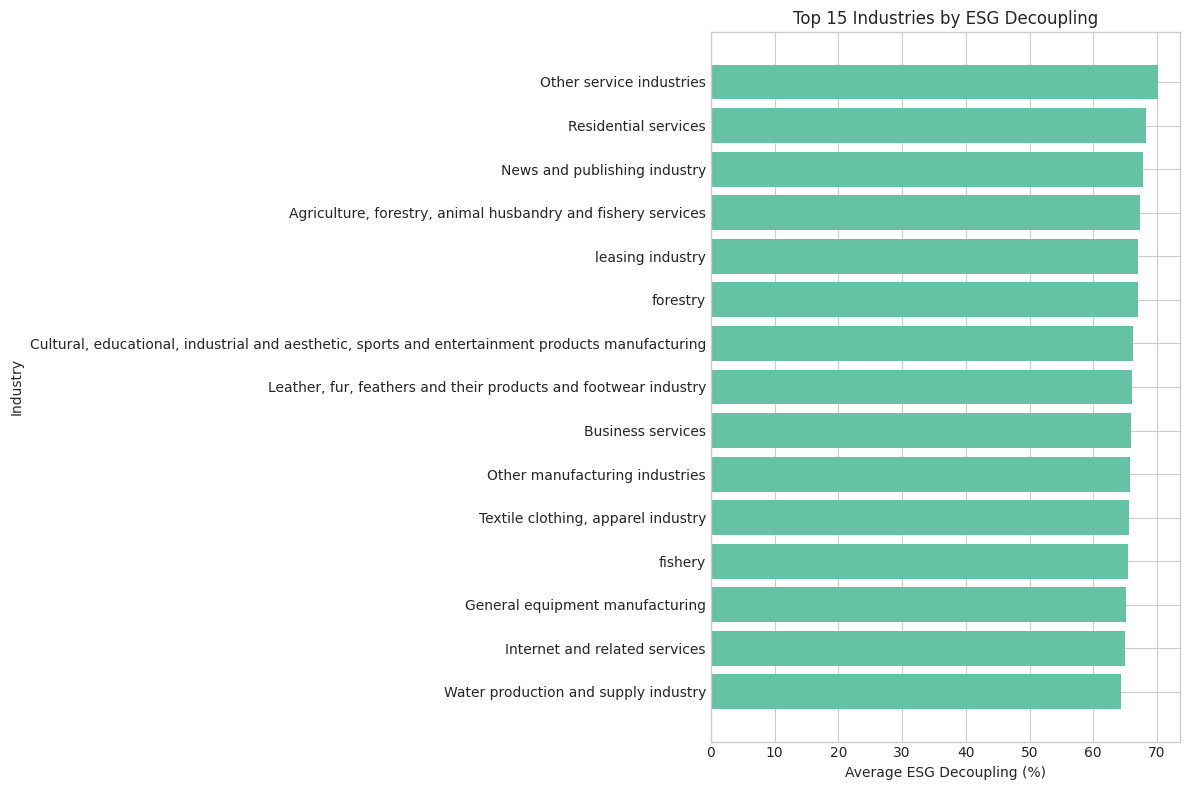

In [12]:
# 1.3 Analyze decoupling by industry
# Calculate average decoupling metrics by industry
industry_decoupling = data.groupby('industry_name')[
    ['esg_decoupling', 'e_decoupling', 's_decoupling', 'g_decoupling']
].agg(['mean', 'count']).reset_index()

# Filter for industries with at least 3 observations for reliability
industry_decoupling_filtered = industry_decoupling[
    industry_decoupling[('esg_decoupling', 'count')] >= 3
].sort_values(('esg_decoupling', 'mean'), ascending=False)

# Display results
print("\nESG Decoupling by Industry (Top 5):")
print(industry_decoupling_filtered.head(5))

# Visualize top 15 industries by decoupling
top_15_industries = industry_decoupling_filtered.head(15)
industries = [str(industry) for industry in top_15_industries['industry_name'].tolist()]
decoupling_values = top_15_industries[('esg_decoupling', 'mean')].tolist()

# Check for any missing or non-string values
print("Top 15 Industry names:", industries)
print("Top 15 Decoupling values:", decoupling_values)

# Calculate the min and max for the top 15 values
min_val = min(decoupling_values)
max_val = max(decoupling_values)


value_range = max_val - min_val
padding = value_range * 0.03 # Add 5% padding on each side

x_min_limit = max(0, min_val - padding) # Don't go below zero unless intended
x_max_limit = max_val + padding

print(f"Setting X-axis limits from {x_min_limit:.2f} to {x_max_limit:.2f}")


# Make the plot with explicit casting to strings
plt.figure(figsize=(12, 8))
plt.barh(industries, decoupling_values)
plt.gca().invert_yaxis()
plt.xlabel('Average ESG Decoupling (%)')
plt.ylabel('Industry')
plt.title('Top 15 Industries by ESG Decoupling')
plt.tight_layout()
plt.savefig('top_15_industry_decoupling.png')
plt.show()




## Identifying High-Risk Companies and Analyzing Decoupling Distribution

This section focuses on pinpointing the companies with the most significant disparities between their Bloomberg ESG ratings and independent assessments, while also analyzing the overall distribution of decoupling across our dataset.

#### Company-Level Decoupling Analysis

This code aggregates ESG decoupling scores at the company level, calculating the average decoupling percentage for each company across all available time periods. By sorting these values in descending order, we can identify the companies with the most substantial rating inconsistencies,potential candidates for closer examination of ESG reporting practices or possible greenwashing.

#### Statistical Distribution of Decoupling

The histogram visualization provides crucial statistical context for our findings. It reveals the frequency distribution of ESG decoupling scores across all observations, helping establish what constitutes "normal" versus "exceptional" levels of inconsistency.
The inclusion of both mean (red dashed line) and median (green dash-dot line) values allows us to assess the symmetry of the distribution. A significant difference between these values would indicate skewness, suggesting that outliers might be distorting our understanding of typical decoupling levels.


Top 10 Companies with Highest ESG Decoupling:
          id                         company_name  \
1292  601929                          Jishi Media   
496     2617                    Luxiao Technology   
404     2400                 Shengguang Co., Ltd.   
595   300111                            sunflower   
364     2297                  Boyun New Materials   
278     2113                     Tianrun Holdings   
617   300204                        God of Shutai   
504     2646           Green highland barley wine   
620   300215  Institute of Electrical Engineering   
568   300022        Jifeng Agricultural Machinery   

                                          industry_name  esg_decoupling  
1292  Telecommunications, radio and television and s...       87.025193  
496   Nonferrous metal smelting and rolling processi...       85.445586  
404                                   Business services       85.204792  
595   Computer, communications and other electronic ...       85.061665  

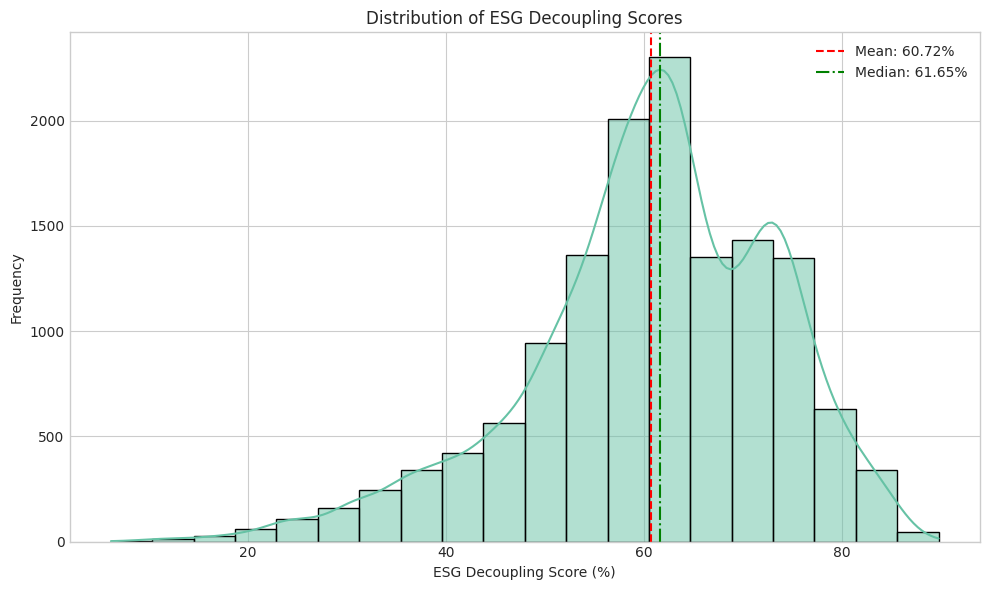

In [13]:
# 1.4 Identify companies with highest ESG decoupling
top_decoupling_companies = data.groupby(['id', 'company_name', 'industry_name'])['esg_decoupling'].mean().reset_index()
top_decoupling_companies = top_decoupling_companies.sort_values('esg_decoupling', ascending=False)

print("\nTop 10 Companies with Highest ESG Decoupling:")
print(top_decoupling_companies.head(10))

# 1.5 Distribution of decoupling scores
plt.figure(figsize=(10, 6))
sns.histplot(data['esg_decoupling'], bins=20, kde=True)
plt.xlabel('ESG Decoupling Score (%)')
plt.ylabel('Frequency')
plt.title('Distribution of ESG Decoupling Scores')
plt.axvline(data['esg_decoupling'].mean(), color='red', linestyle='--', 
            label=f'Mean: {data["esg_decoupling"].mean():.2f}%')
plt.axvline(data['esg_decoupling'].median(), color='green', linestyle='-.',
            label=f'Median: {data["esg_decoupling"].median():.2f}%')
plt.legend()
plt.tight_layout()
plt.savefig('decoupling_distribution.png')
plt.show()


# 2. Analyze relationship between news sentiment and ESG ratings

#### Comparing News Sentiment with ESG Ratings
This section examines the relationship between media perception and formal ESG assessments, a critical dimension of our ESG decoupling investigation.

The code first normalizes ESG scores to a 0-1 scale to enable direct comparison with sentiment scores. This standardization is essential as the original ESG scores typically range from 0-100, while our calculated sentiment scores span from -1 to 1.
We then calculate Pearson correlation coefficients between news sentiment and both rating systems. These correlations quantify how closely media coverage aligns with formal ESG assessments, revealing whether companies portrayed positively in the news tend to receive higher ESG ratings.

In [14]:
from scipy import stats

# Normalize ESG scores to 0–1 scale
data['bloomberg_esg_norm'] = data['bloomberg_esg'] / 100
data['comprehensive_score_norm'] = data['comprehensive_score'] / 100

# Calculate both Pearson's and Spearman's correlations
sentiment_correlations = {
    'Bloomberg ESG': {
        'Pearson': stats.pearsonr(data['sentiment_score'], data['bloomberg_esg_norm']),
        'Spearman': stats.spearmanr(data['sentiment_score'], data['bloomberg_esg_norm'])
    },
    'Independent ESG': {
        'Pearson': stats.pearsonr(data['sentiment_score'], data['comprehensive_score_norm']),
        'Spearman': stats.spearmanr(data['sentiment_score'], data['comprehensive_score_norm'])
    }
}

# Print correlation results
print("\nCorrelation between News Sentiment and ESG Ratings:")
for rating_type, methods in sentiment_correlations.items():
    print(f"\n{rating_type}:")
    print(f"  Pearson:  r = {methods['Pearson'][0]:.3f}, p-value = {methods['Pearson'][1]:.3e}")
    print(f"  Spearman: r = {methods['Spearman'].correlation:.3f}, p-value = {methods['Spearman'].pvalue:.3e}")



Correlation between News Sentiment and ESG Ratings:

Bloomberg ESG:
  Pearson:  r = 0.104, p-value = 3.468e-34
  Spearman: r = 0.090, p-value = 4.914e-26

Independent ESG:
  Pearson:  r = 0.176, p-value = 1.131e-95
  Spearman: r = 0.116, p-value = 2.148e-42


### Visualizing the Relationship Between News Sentiment and ESG Ratings
This visualization provides a direct comparison between how news sentiment relates to both Bloomberg and independent ESG ratings, allowing us to identify potential disconnects between media perception and formal ESG assessments.

Left panel: Shows the relationship between Bloomberg ESG scores and news sentiment  
Right panel: Displays how independent ESG ratings correlate with the same sentiment data  

Each point represents a company, with its position revealing how its ESG ratings align with its media perception. The correlation coefficient embedded in each title provides a precise measure of relationship strength.

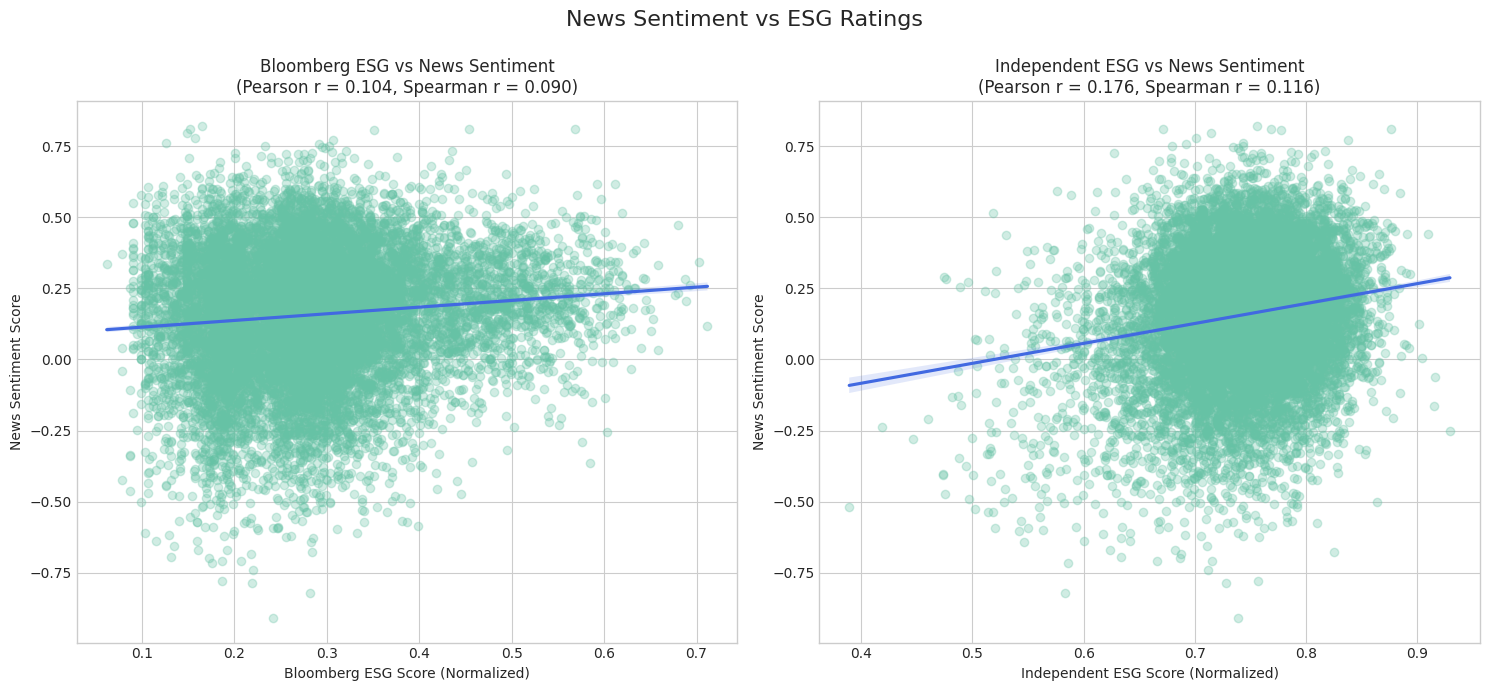

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('News Sentiment vs ESG Ratings', fontsize=16)

# Bloomberg ESG vs Sentiment
pearson_b, spearman_b = sentiment_correlations["Bloomberg ESG"]["Pearson"], sentiment_correlations["Bloomberg ESG"]["Spearman"]
sns.regplot(
    x='bloomberg_esg_norm', y='sentiment_score', data=data, ax=axes[0],
    line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3}
)
axes[0].set_title(
    f'Bloomberg ESG vs News Sentiment\n(Pearson r = {pearson_b[0]:.3f}, Spearman r = {spearman_b.correlation:.3f})'
)
axes[0].set_xlabel('Bloomberg ESG Score (Normalized)')
axes[0].set_ylabel('News Sentiment Score')

# Independent ESG vs Sentiment
pearson_i, spearman_i = sentiment_correlations["Independent ESG"]["Pearson"], sentiment_correlations["Independent ESG"]["Spearman"]
sns.regplot(
    x='comprehensive_score_norm', y='sentiment_score', data=data, ax=axes[1],
    line_kws={'color': 'royalblue'}, scatter_kws={'alpha': 0.3}
)
axes[1].set_title(
    f'Independent ESG vs News Sentiment\n(Pearson r = {pearson_i[0]:.3f}, Spearman r = {spearman_i.correlation:.3f})'
)
axes[1].set_xlabel('Independent ESG Score (Normalized)')
axes[1].set_ylabel('News Sentiment Score')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('sentiment_vs_esg.png')
plt.show()

### K-Means Clustering: 
This section applies machine learning to identify natural groupings in how companies' ESG ratings relate to their media perception. The K-means clustering algorithm helps us discover inherent patterns without imposing arbitrary thresholds.

We first standardize our data points to ensure both ESG scores and sentiment values have equal influence on the clustering process. The algorithm then partitions companies into four distinct clusters based on the similarity of their ESG-sentiment profiles.

The red X markers indicate cluster centers, while points are colored according to their cluster assignment. This visualization provides immediate insight into how companies naturally group based on the relationship between their ESG performance and media perception. Each cluster represents a distinct ESG-sentiment profile



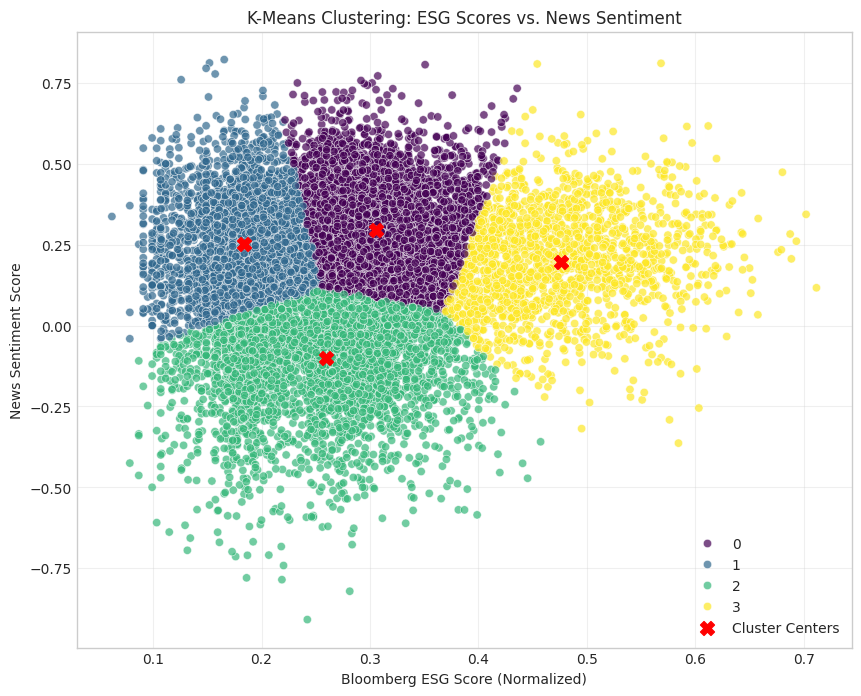


K-Means Clustering Results:
  cluster bloomberg_esg_norm       sentiment_score
                        mean count            mean
0       0           0.305676  4971        0.295163
1       1           0.184007  3036        0.250502
2       2           0.259549  4038       -0.099305
3       3           0.476255  1647        0.197437

Cluster Interpretation:
Cluster     0.0
Name: 0, dtype: float64: Low ESG, Positive Sentiment (4971.0 companies)
Cluster     1.0
Name: 1, dtype: float64: Low ESG, Positive Sentiment (3036.0 companies)
Cluster     2.0
Name: 2, dtype: float64: Low ESG, Negative Sentiment (4038.0 companies)
Cluster     3.0
Name: 3, dtype: float64: Low ESG, Positive Sentiment (1647.0 companies)


In [16]:
# 2.3 K-means clustering to identify patterns
# Prepare data for clustering
cluster_data = data[['bloomberg_esg_norm', 'sentiment_score']].copy().dropna()

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)

# Apply K-means clustering (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

# Calculate cluster centers in original scale
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(centers, columns=['bloomberg_esg_norm', 'sentiment_score'])
cluster_centers['cluster'] = range(len(cluster_centers))

# Visualize clustering results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='bloomberg_esg_norm', y='sentiment_score', hue='cluster', 
                data=cluster_data, palette='viridis', alpha=0.7)

# Add cluster centers
plt.scatter(cluster_centers['bloomberg_esg_norm'], cluster_centers['sentiment_score'], 
            c='red', s=100, marker='X', label='Cluster Centers')

plt.xlabel('Bloomberg ESG Score (Normalized)')
plt.ylabel('News Sentiment Score')
plt.title('K-Means Clustering: ESG Scores vs. News Sentiment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('sentiment_esg_clustering.png')
plt.show()

# Analyze the clusters
cluster_stats = cluster_data.groupby('cluster').agg({
    'bloomberg_esg_norm': ['mean', 'count'],
    'sentiment_score': 'mean'
}).reset_index()

print("\nK-Means Clustering Results:")
print(cluster_stats)

# Label the clusters for interpretation
cluster_interpretation = []
for _, row in cluster_stats.iterrows():
    esg_level = "High" if row[('bloomberg_esg_norm', 'mean')] > 0.5 else "Low"
    sentiment_level = "Positive" if row[('sentiment_score', 'mean')] > 0 else "Negative"
    interpretation = f"Cluster {row['cluster']}: {esg_level} ESG, {sentiment_level} Sentiment ({row[('bloomberg_esg_norm', 'count')]} companies)"
    cluster_interpretation.append(interpretation)

print("\nCluster Interpretation:")
for interp in cluster_interpretation:
    print(interp)


#### Identifying Companies with ESG-Media Perception Misalignment
This section focuses on quantifying and ranking companies based on the degree of misalignment between their ESG ratings and media perception, a potential indicator of greenwashing or inadequate ESG assessment.

We create a disconnect metric by taking the absolute difference between each company's news sentiment score and its normalized Bloomberg ESG rating. This approach captures misalignment regardless of direction—whether a company has better ESG ratings than its news coverage would suggest (potential greenwashing) or better news sentiment than its ESG ratings reflect (potentially undervalued sustainability performance).  

After calculating this metric for all observations, we aggregate to the company level by averaging the disconnect scores across all time periods. This provides a more stable measure that isn't overly influenced by temporary fluctuations in either ratings or news coverage.  
 
The resulting ranked list identifies companies where formal ESG assessments diverge most significantly from public perception as reflected in news sentiment. These high-disconnect companies represent particularly interesting cases for further investigation:  

Companies with high ESG scores but negative news sentiment may be successfully projecting a positive sustainability image to rating agencies while facing criticism in the media  
Companies with positive news coverage but low ESG ratings might have sustainability initiatives that aren't being fully captured by formal ESG assessment methodologies  

In [17]:
# 2.4 Companies with largest news-ESG disconnect
# Calculate news sentiment vs ESG scores disconnect
data['sentiment_esg_disconnect'] = abs(data['sentiment_score'] - data['bloomberg_esg_norm'])

# Identify companies where sentiment doesn't match ESG scores
disconnect_companies = data.groupby(['id', 'company_name', 'industry_name'])['sentiment_esg_disconnect'].mean().reset_index()
disconnect_companies = disconnect_companies.sort_values('sentiment_esg_disconnect', ascending=False)

print("\nTop 10 Companies with Largest News Sentiment vs ESG Disconnect:")
print(disconnect_companies.head(10))


Top 10 Companies with Largest News Sentiment vs ESG Disconnect:
          id            company_name  \
1102  600816             Anxin Trust   
1052  600715            *ST Songliao   
1318  603195              bull group   
631   300278             Hua Changda   
1205  601138          Industrial Fii   
860   600331           Hongda shares   
198      980            Jinma shares   
767   600115  China Eastern Airlines   
0          2                 Vanke A   
999   600601      Founder Technology   

                                          industry_name  \
1102                            capital market services   
1052                  automobile manufacturing industry   
1318  Electrical machinery and equipment manufacturi...   
631                     Special equipment manufacturing   
1205  Computer, communications and other electronic ...   
860   Chemical raw materials and chemical products m...   
198                   automobile manufacturing industry   
767                   

### Categorizing Companies by ESG-Media Alignment
This section develops a clear taxonomy for classifying companies based on the relationship between their ESG ratings and news sentiment, providing a structured framework for identifying potential misalignments.

We establish meaningful thresholds (0.6 for ESG scores, 0.2 for sentiment) to classify companies into four distinct categories, each with specific implications for ESG reporting quality:

High ESG & Positive News: Companies with aligned positive assessments from both rating agencies and media coverage  
Low ESG & Positive News: Companies receiving more favorable media coverage than their formal ESG ratings would suggest  
High ESG & Negative News: Companies with strong ESG ratings but poor media perception—potential greenwashing candidates  
Low ESG & Negative News: Companies with aligned negative assessments across both dimensions  



To categorize companies based on their ESG performance and associated news sentiment, we established thresholds for the normalized Bloomberg ESG score (bloomberg_esg_norm, scale 0-1) and the calculated sentiment score (sentiment_score, scale approx. -1 to +1).

For ESG performance, we define 'High ESG' as scores strictly greater than 0.5. This threshold represents the midpoint of the normalized scale, providing a clear and neutral division between companies performing above or below the median point of the theoretical range.

For news sentiment, we define 'Positive News' as scores strictly greater than 0.0. This threshold aligns directly with the definition of the sentiment score, where zero indicates perfect neutrality or balance. Any score above zero signifies a net positive sentiment in the analyzed news data. Scores less than or equal to zero are categorized as 'Neutral/Negative News'.

These thresholds (ESG > 0.5, Sentiment > 0.0) were chosen for their direct interpretability based on the scales of the variables, providing a balanced and theoretically grounded approach to segmenting the observations into four distinct categories:

Aligned: High ESG & Positive News (ESG > 0.5, Sentiment > 0.0)

Decoupled: Low/Mid ESG & Positive News (ESG <= 0.5, Sentiment > 0.0)

Decoupled: High ESG & Neutral/Negative News (ESG > 0.5, Sentiment <= 0.0)

Aligned: Low/Mid ESG & Neutral/Negative News (ESG <= 0.5, Sentiment <= 0.0)

This categorization allows for analysis of alignment and potential decoupling between reported ESG scores and public perception reflected in news sentiment.


Companies by Sentiment-ESG Relationship:
sentiment_esg_category
Low ESG & Positive News     10105
Low ESG & Negative News      3051
High ESG & Positive News      485
High ESG & Negative News       51
Name: count, dtype: int64


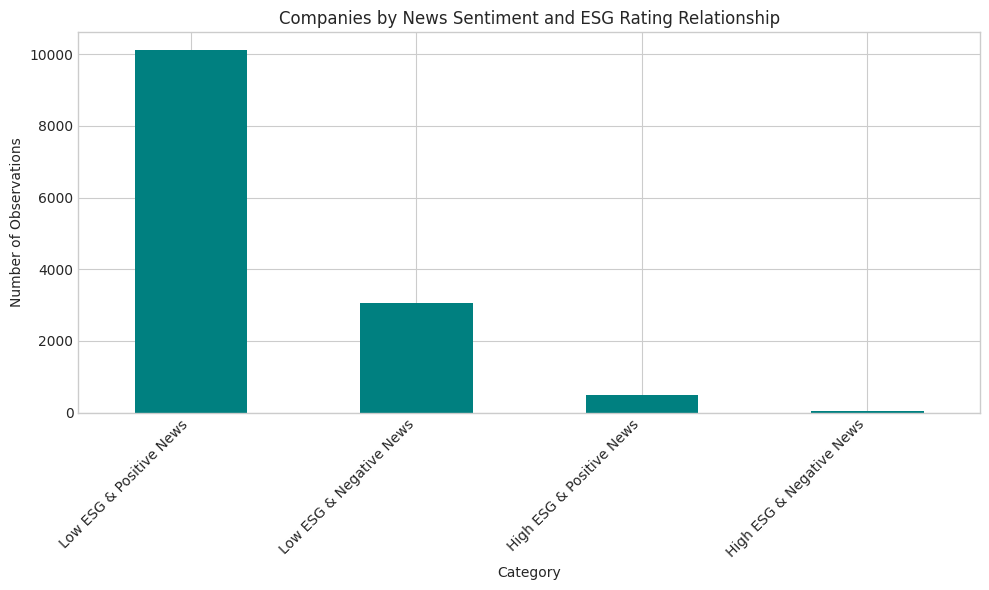


SUMMARY OF NEWS SENTIMENT FINDINGS:
1. Bloomberg ESG vs News Sentiment:
   - Pearson r = 0.104, p = 3.468e-34
   - Spearman r = 0.090, p = 4.914e-26
2. Independent ESG vs News Sentiment:
   - Pearson r = 0.176, p = 1.131e-95
   - Spearman r = 0.116, p = 2.148e-42
3. Most common sentiment-ESG relationship: Low ESG & Positive News (10105 observations)
4. Average sentiment-ESG disconnect: 0.209
5. Category with largest sentiment-ESG disconnect: High ESG & Negative News (avg: 0.635)


In [19]:
# 2.5 Categorize companies by sentiment-ESG relationship

# Categorization function
def categorize_sentiment_esg(row):
    if row['sentiment_score'] > 0.0 and row['bloomberg_esg_norm'] > 0.5:
        return "High ESG & Positive News"
    elif row['sentiment_score'] > 0.0 and row['bloomberg_esg_norm'] <= 0.5:
        return "Low ESG & Positive News"
    elif row['sentiment_score'] <= 0.0 and row['bloomberg_esg_norm'] > 0.5:
        return "High ESG & Negative News"
    else:
        return "Low ESG & Negative News"

# Apply categorization
data['sentiment_esg_category'] = data.apply(categorize_sentiment_esg, axis=1)

# Count companies in each category
category_counts = data['sentiment_esg_category'].value_counts()

# Display category counts
print("\nCompanies by Sentiment-ESG Relationship:")
print(category_counts)

# Visualize categories
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='teal')
plt.xlabel('Category')
plt.ylabel('Number of Observations')
plt.title('Companies by News Sentiment and ESG Rating Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sentiment_esg_categories.png')
plt.show()

# Summary of news sentiment findings
pearson_b, spearman_b = sentiment_correlations['Bloomberg ESG']['Pearson'], sentiment_correlations['Bloomberg ESG']['Spearman']
pearson_i, spearman_i = sentiment_correlations['Independent ESG']['Pearson'], sentiment_correlations['Independent ESG']['Spearman']

print("\nSUMMARY OF NEWS SENTIMENT FINDINGS:")
print(f"1. Bloomberg ESG vs News Sentiment:")
print(f"   - Pearson r = {pearson_b[0]:.3f}, p = {pearson_b[1]:.3e}")
print(f"   - Spearman r = {spearman_b.correlation:.3f}, p = {spearman_b.pvalue:.3e}")
print(f"2. Independent ESG vs News Sentiment:")
print(f"   - Pearson r = {pearson_i[0]:.3f}, p = {pearson_i[1]:.3e}")
print(f"   - Spearman r = {spearman_i.correlation:.3f}, p = {spearman_i.pvalue:.3e}")

# Most common category
most_common = category_counts.idxmax()
print(f"3. Most common sentiment-ESG relationship: {most_common} ({category_counts[most_common]} observations)")

# Average disconnect
avg_disconnect = data['sentiment_esg_disconnect'].mean()
print(f"4. Average sentiment-ESG disconnect: {avg_disconnect:.3f}")

# Largest disconnect category
disconnect_by_category = data.groupby('sentiment_esg_category')['sentiment_esg_disconnect'].mean()
max_disconnect_category = disconnect_by_category.idxmax()
print(f"5. Category with largest sentiment-ESG disconnect: {max_disconnect_category} (avg: {disconnect_by_category[max_disconnect_category]:.3f})")


### ESG Decoupling Analysis - Step 3: Industry Patterns and Predictive Modeling



### Industry and Regional Analysis of ESG Decoupling
This section examines how ESG decoupling patterns vary across different industry types and geographical regions, providing insight into structural factors that may influence rating inconsistencies.

We first create binary classifications for key industry characteristics, categorizing companies as high-technology, polluting, both, or neither. This approach allows us to move beyond traditional industry classifications to focus on specific business attributes that might influence ESG reporting practices and assessment methodologies.  
The comparative analysis reveals whether certain industry types exhibit systematically higher levels of ESG decoupling. For instance, highly polluting industries might face greater scrutiny from rating agencies but also more negative news coverage, potentially creating unique patterns of misalignment between formal ESG assessments and public perception.

Regional patterns may reflect differences in regulatory environments, reporting standards, or market pressures across different areas. This geographical dimension adds crucial context to our understanding of ESG decoupling phenomena.

The culmination of this analysis is the region-industry heatmap, which visualizes how decoupling varies across both dimensions simultaneously. This multi-factor approach helps identify specific combinations—such as high-tech companies in the West or polluting industries in the East—that might exhibit particularly notable ESG rating inconsistencies.


ESG Decoupling by Industry Type:
           Industry Type   Mean  Median   Std  Count
1         Polluting Only  49.33   49.39  9.39   1900
0       Other Industries  49.23   49.54  8.96   4119
2         High-Tech Only  48.59   48.43  8.97   4334
3  High-Tech & Polluting  48.06   48.44  9.56   3339


/tmp/ipykernel_21790/1030110838.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tech_vs_polluting.sort_values('Mean', ascending=False),


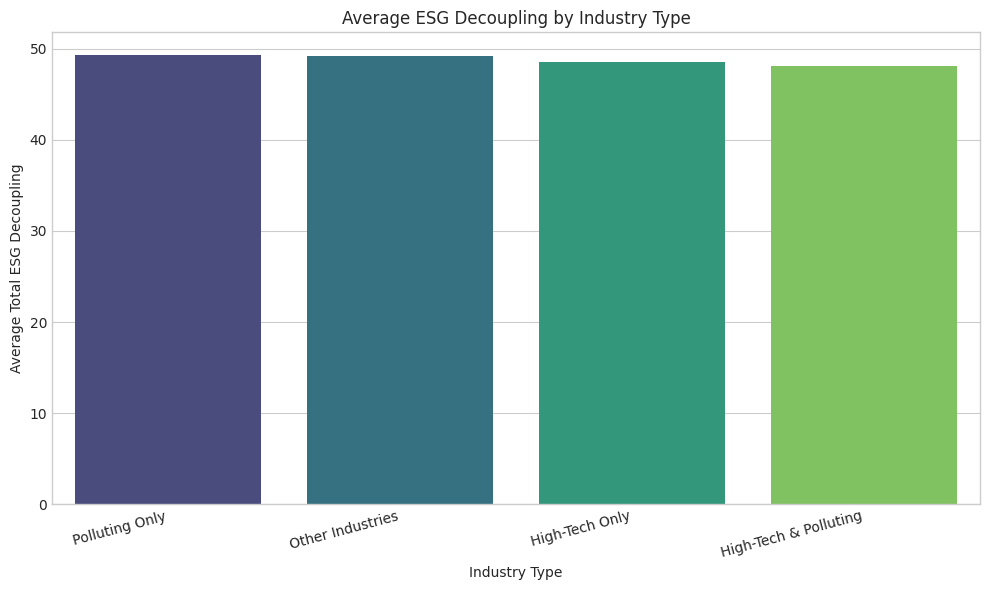


ESG Decoupling by Region:
  Region_Label   Mean  Median    Std  Count
3         West  49.34   49.55   9.15   2364
1          Mid  49.25   49.41   9.50   2020
0         East  48.72   48.81   8.99   9047
2  Unspecified  41.16   41.63  10.22    261


/tmp/ipykernel_21790/1030110838.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=regional_decoupling.sort_values('Mean', ascending=False),


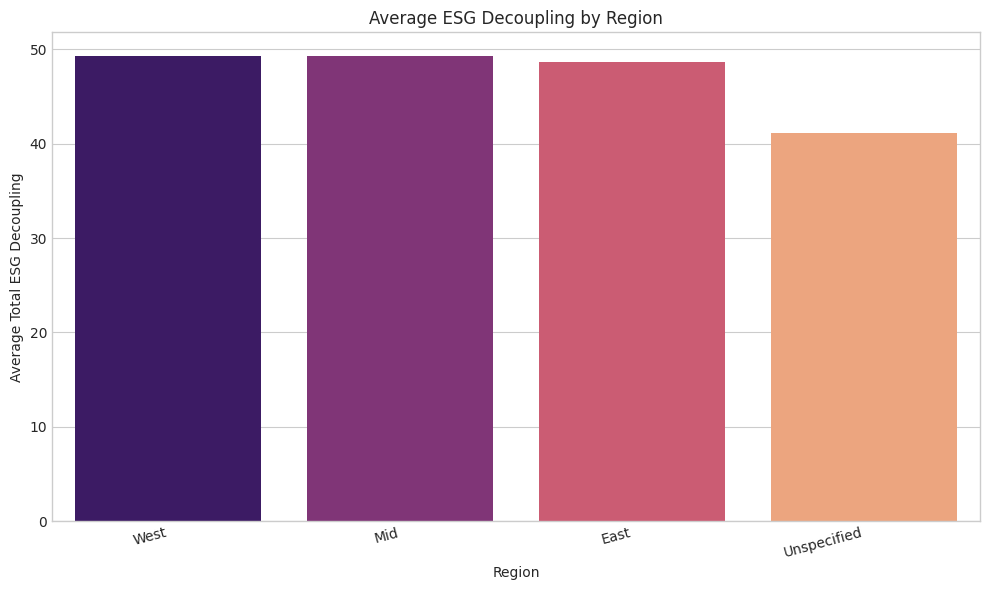

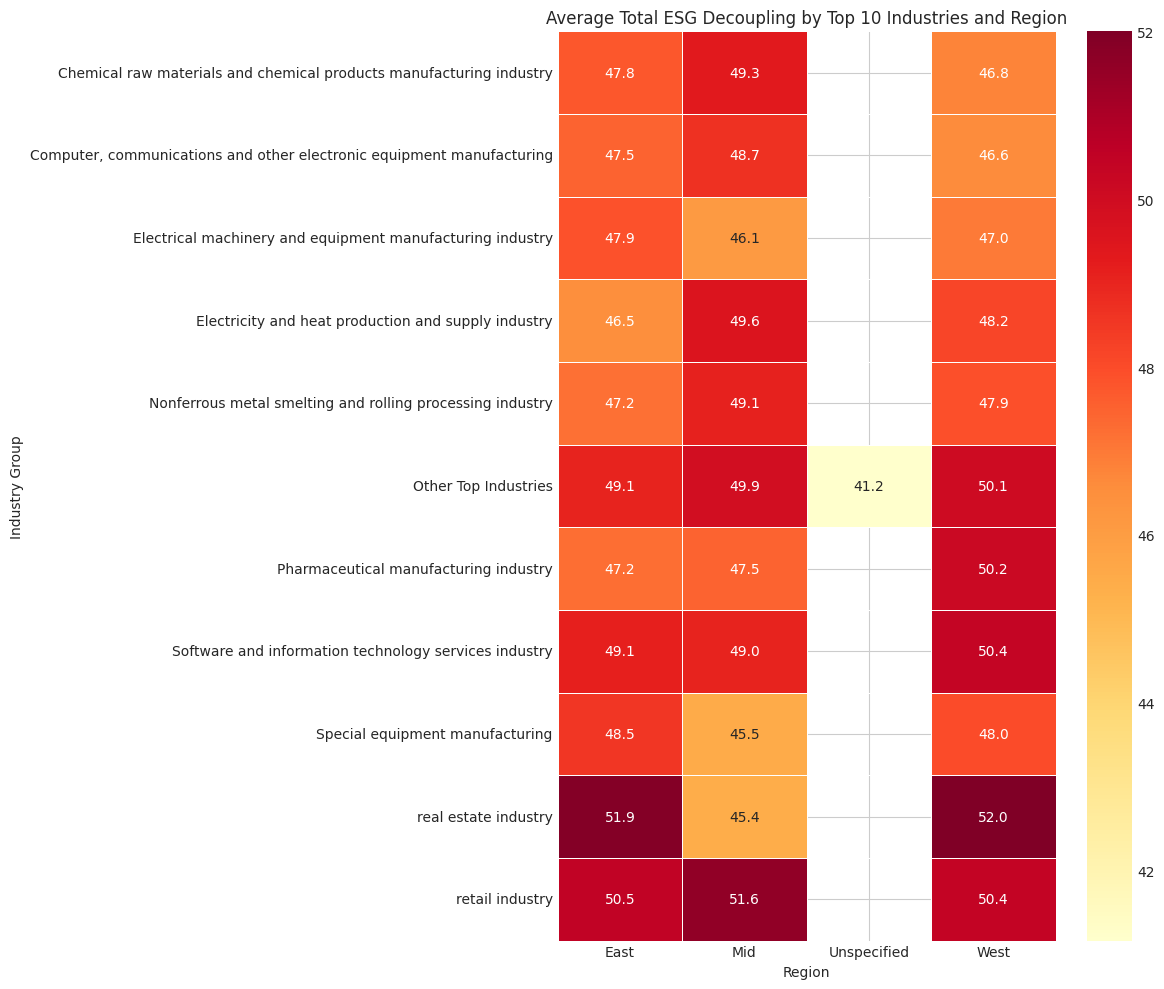

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- Create High-Tech and Polluting Industry Indicators ---
# Assumes columns hightech_1, hightech_2 exist
data['is_hightech'] = ((data['hightech_1'] == 1) | (data['hightech_2'] == 1)).astype(int)
# Assumes columns pollute_1, pollute_2, pollute_3 exist
data['is_polluting'] = ((data['pollute_1'] == 1) | (data['pollute_2'] == 1) |
                     (data['pollute_3'] == 1)).astype(int)

# --- Compare Decoupling in High-Tech vs. Polluting Industries ---

# Define labels for industry types based on flags
def get_industry_type_label(row):
    is_tech = row['is_hightech'] == 1
    is_polluting = row['is_polluting'] == 1
    if is_tech and is_polluting:
        return "High-Tech & Polluting"
    elif is_tech:
        return "High-Tech Only"
    elif is_polluting:
        return "Polluting Only"
    else:
        return "Other Industries"

# Group data and apply label function
tech_vs_polluting = data.groupby(['is_hightech', 'is_polluting'])['total_decoupling'].agg(
    Mean='mean', Median='median', Std='std', Count='count'
).reset_index()

tech_vs_polluting['Industry Type'] = tech_vs_polluting.apply(get_industry_type_label, axis=1)

print("\nESG Decoupling by Industry Type:")
print(tech_vs_polluting.sort_values('Mean', ascending=False)[['Industry Type', 'Mean', 'Median', 'Std', 'Count']].round(2))

# Create bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=tech_vs_polluting.sort_values('Mean', ascending=False),
            x='Industry Type', y='Mean', palette='viridis')
plt.xlabel('Industry Type')
plt.ylabel('Average Total ESG Decoupling')
plt.title('Average ESG Decoupling by Industry Type')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('industry_type_decoupling.png')
plt.show()


# --- Regional Analysis ---
# Assumes columns east, west, mid exist

# Define labels for regions based on flags
def get_region_label(row):
    is_east = row['east'] == 1
    is_west = row['west'] == 1
    is_mid = row['mid'] == 1
    regions = []
    if is_east: regions.append("East")
    if is_west: regions.append("West")
    if is_mid: regions.append("Mid")

    if len(regions) == 0:
        return "Unspecified"
    elif len(regions) == 1:
        return regions[0]
    else:
        return " & ".join(regions) # Handles combinations

# Apply region labels to the original data
data['Region_Label'] = data.apply(get_region_label, axis=1)

# Group by the generated label
regional_decoupling = data.groupby('Region_Label')['total_decoupling'].agg(
    Mean='mean', Median='median', Std='std', Count='count'
).reset_index()

print("\nESG Decoupling by Region:")
print(regional_decoupling.sort_values('Mean', ascending=False).round(2))

# Plot regional decoupling using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=regional_decoupling.sort_values('Mean', ascending=False),
            x='Region_Label', y='Mean', palette='magma')
plt.xlabel('Region')
plt.ylabel('Average Total ESG Decoupling')
plt.title('Average ESG Decoupling by Region')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('regional_decoupling.png')
plt.show()

# --- Create Region-Industry Heatmap ---
# Assume one of these exists
industry_col = 'industry_name' if 'industry_name' in data.columns else 'industry_category'

# Prepare data for heatmap
heatmap_data = data[['Region_Label', industry_col, 'total_decoupling']].copy()
heatmap_data[industry_col] = heatmap_data[industry_col].fillna('Unknown')
heatmap_data = heatmap_data.dropna(subset=['total_decoupling', 'Region_Label'])

# Get top N industries
N_TOP_INDUSTRIES = 10
top_industries = heatmap_data[industry_col].value_counts().head(N_TOP_INDUSTRIES).index.tolist()
heatmap_data['Industry_Group'] = heatmap_data[industry_col].apply(
    lambda x: x if x in top_industries else 'Other Top Industries'
    )

    # Create pivot table using the Region_Label
region_industry_pivot = pd.pivot_table(
        data=heatmap_data,
        values='total_decoupling',
        index=['Industry_Group'],
        columns=['Region_Label'],
        aggfunc='mean'
    )

    # Basic check if pivot table is empty
if region_industry_pivot.empty:
    print("Warning: Pivot table is empty. Skipping heatmap.")
else:
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(region_industry_pivot, annot=True, cmap='YlOrRd', fmt='.1f', linewidths=.5)
    plt.title(f'Average Total ESG Decoupling by Top {N_TOP_INDUSTRIES} Industries and Region')
    plt.xlabel('Region')
    plt.ylabel('Industry Group')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('region_industry_heatmap.png')
    plt.show()

### Predictive Modeling for ESG Decoupling
This section moves beyond descriptive analysis to identify factors that predict ESG decoupling through machine learning techniques. By building predictive models, we can determine which company characteristics and metrics most strongly contribute to rating inconsistencies.

We select a combination of ESG metrics (Bloomberg and independent ratings, sentiment scores) and company characteristics (industry type, regional indicators) as potential predictors. Our target variable is the total decoupling score, which measures the overall inconsistency between ESG ratings and news sentiment.

We implement three distinct modeling approaches, each with different strengths:  

- Linear Regression captures straightforward relationships between variables  
- Random Forest identifies non-linear patterns and interactions   
- XGBoost provides state-of-the-art predictive performance for structured data  

The comparative performance analysis reveals which model best captures the underlying patterns in ESG decoupling. More importantly, by examining feature importance or coefficients from the best model, we identify which factors most strongly predict rating inconsistencies:

This feature importance ranking offers crucial insights into the drivers of ESG decoupling. Understanding which factors most strongly predict inconsistencies can help investors identify companies at risk of greenwashing, guide regulators toward more effective disclosure requirements, and help rating agencies refine their methodologies to better align with public perception and actual sustainability performance


--- 3.2 PREDICTIVE MODELING FOR ESG DECOUPLING ---
Rows remaining after dropping NaN target: 13692
Training set size: 10953, Test set size: 2739
                       RMSE        R²
XGBoost            8.024715  0.595746
Linear Regression  8.340594  0.563294
Random Forest      8.538504  0.542324

Best performing model (based on R²): XGBoost

Generating evaluation plots for XGBoost...


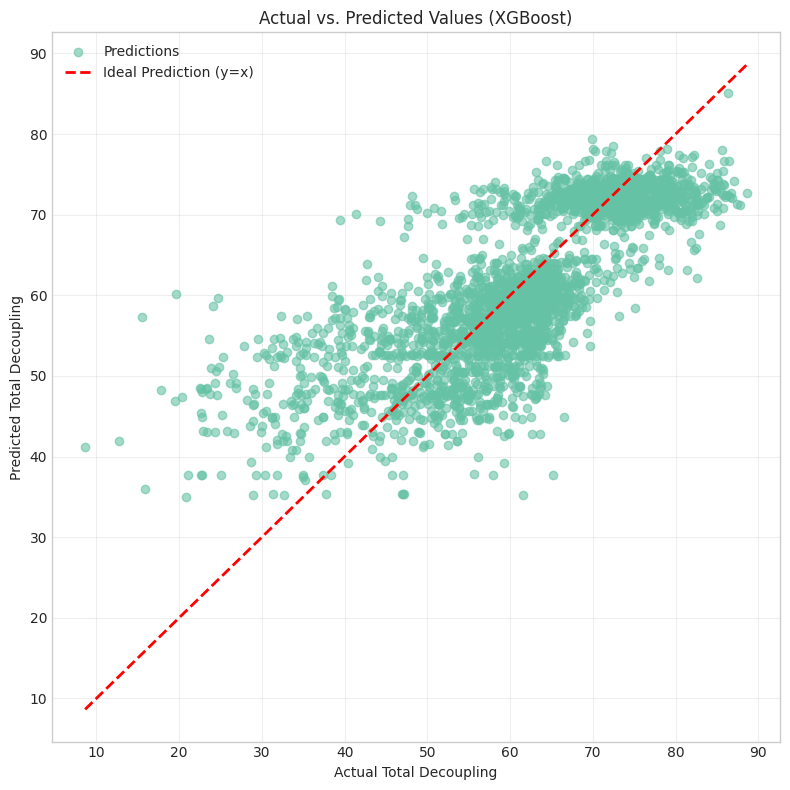

  Plotting Residuals vs. Predicted


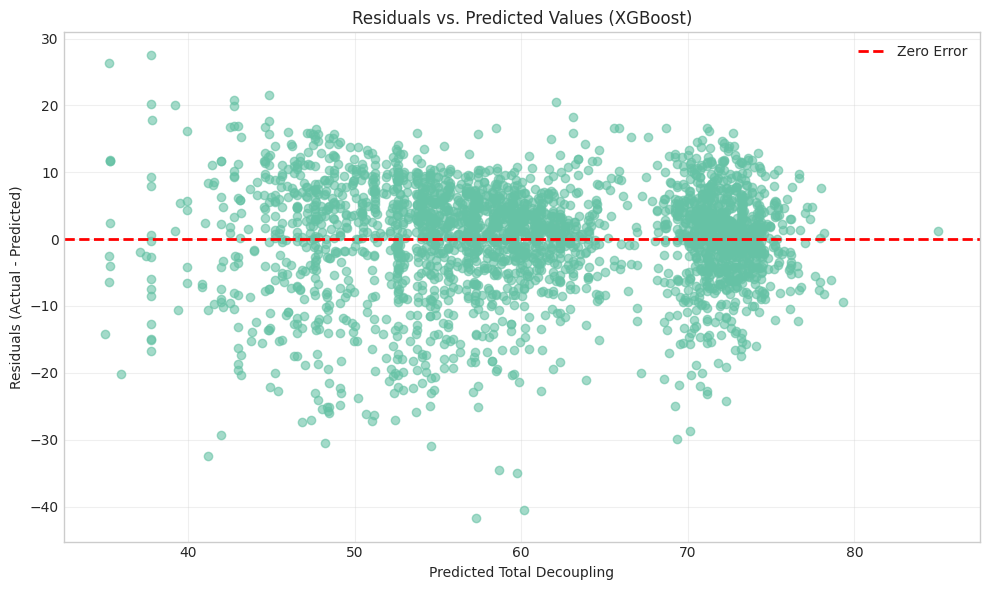

  Plotting Distribution of Residuals


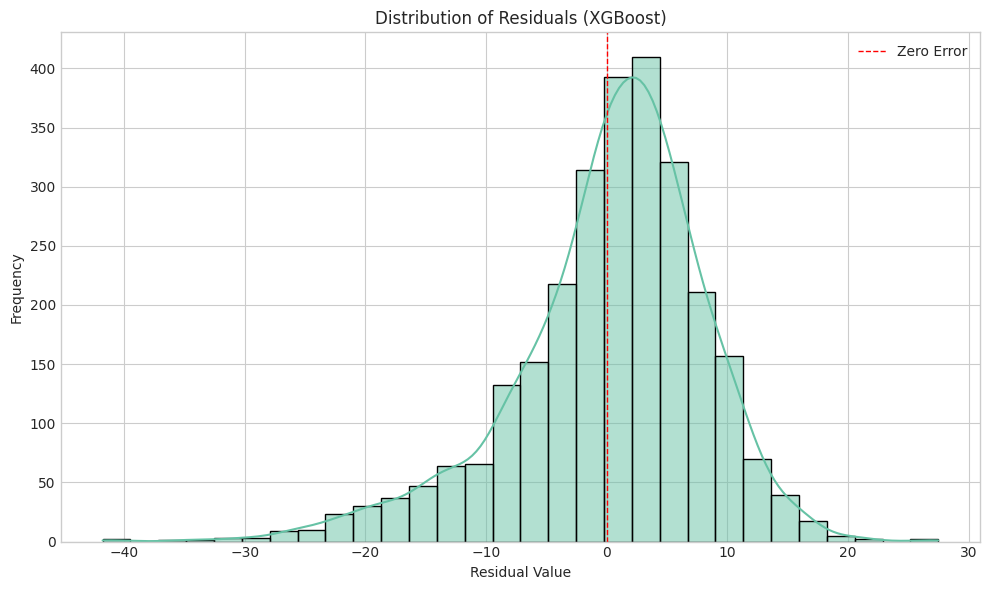

  Retrieved 83 feature names after preprocessing.

Feature Importance (XGBoost):
                                              Feature  Importance
0                                           num__year    0.070022
6                                   num__is_polluting    0.043612
51  cat__industry_name_Software and information te...    0.035678
5                                    num__is_hightech    0.033639
40  cat__industry_name_Petroleum processing, cokin...    0.031682
74              cat__industry_name_insurance industry    0.027792
23  cat__industry_name_Ferrous metal smelting and ...    0.026190
81        cat__industry_name_water transport industry    0.024741
31    cat__industry_name_News and publishing industry    0.024399
62          cat__industry_name_air transport industry    0.024112
34  cat__industry_name_Nonferrous metal smelting a...    0.023728
15  cat__industry_name_Coal mining and washing ind...    0.022936
77            cat__industry_name_real estate industry    0.02

/tmp/ipykernel_21790/2641524715.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_analysis.head(15), palette='mako') # Changed palette


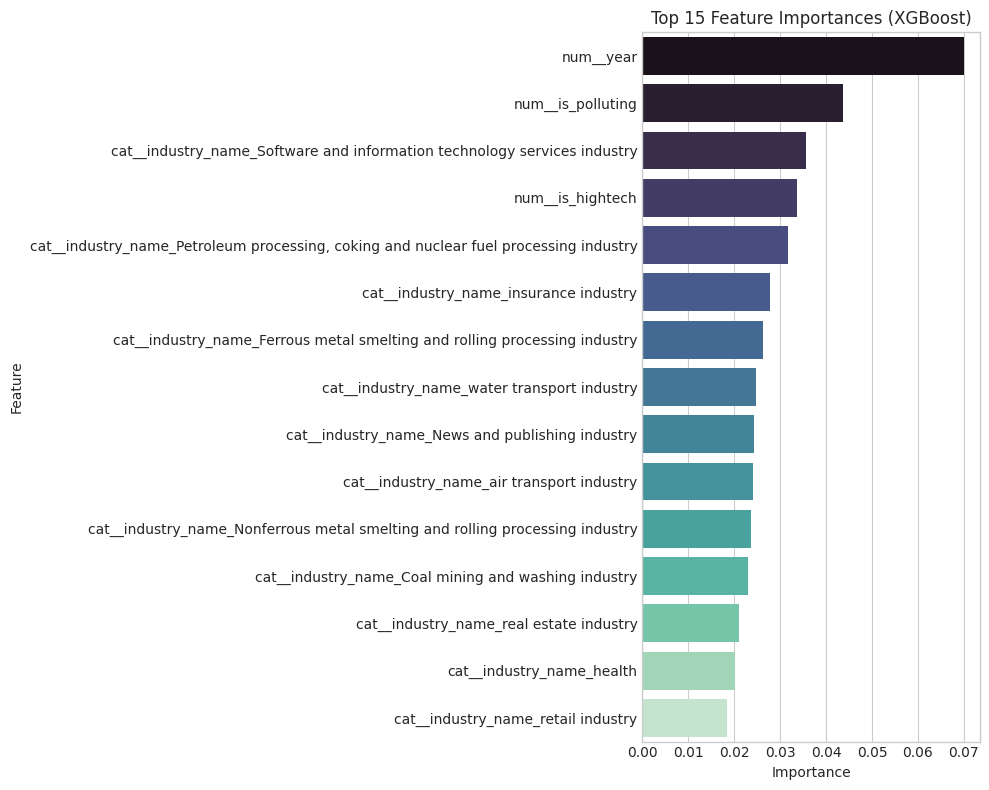

In [23]:
# 3.2 Predictive Modeling for ESG Decoupling
print("\n--- 3.2 PREDICTIVE MODELING FOR ESG DECOUPLING ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# --- Feature and Target Selection ---
# Defining the features and target I'll use for the models.
categorical_features = ['industry_name']
numerical_features = ['year', 'financial_industry', 'east', 'west', 'mid', 'is_hightech', 'is_polluting']
target_variable = 'esg_decoupling'

# Creating a dedicated DataFrame for modeling.
model_df = data[categorical_features + numerical_features + [target_variable]].copy()


# Step 1: Handle Missing Target Values (Crucial: drop rows with NaN target).
model_df.dropna(subset=[target_variable], inplace=True)
print(f"Rows remaining after dropping NaN target: {len(model_df)}")

# Proceed only if there's data left.
if model_df.empty:
    print("No data remaining after handling missing target values. Cannot proceed with modeling.")
else:
    # Step 2: Separate Features (X) and Target (y).
    X = model_df.drop(target_variable, axis=1)
    y = model_df[target_variable]

    # Step 2a: Ensure categorical features are strings (avoids potential encoder errors).
    for col in categorical_features:
        X[col] = X[col].astype(str)

    # Step 3: Split into Training and Testing sets *before* other preprocessing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

    # Step 4: Set up preprocessing pipelines for different feature types.
    # Numerical features: Impute missing values (median) and scale.
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    # Categorical features: Impute missing values (as 'missing') and one-hot encode.
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' helps prevent multicollinearity
    ])
    # Combine preprocessing steps using ColumnTransformer.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep any columns not specified (should be none here).
    )

    # --- Model Training and Evaluation ---
    # Setting up the regression models within pipelines that include preprocessing.
    models = {
        'Linear Regression': Pipeline([('preprocessor', preprocessor),
                                       ('regressor', LinearRegression())]),
        'Random Forest': Pipeline([('preprocessor', preprocessor),
                                   ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))]),
        'XGBoost': Pipeline([('preprocessor', preprocessor),
                             ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42,
                                                            n_estimators=100, early_stopping_rounds=10))])
    }

    # Training each model and storing results.
    results = {}
    trained_models = {}
    for name, pipeline in models.items():
        # XGBoost requires eval_set for early stopping - transform test features first.
        if name == 'XGBoost':
             X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
             pipeline.fit(X_train, y_train, regressor__eval_set=[(X_test_transformed, y_test)], regressor__verbose=False)
        else:
             pipeline.fit(X_train, y_train)

        # Store the fitted model pipeline.
        trained_models[name] = pipeline

        # Evaluate on the test set.
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {'RMSE': rmse, 'R²': r2}

    results_df = pd.DataFrame(results).T.sort_values('R²', ascending=False)
    print(results_df)

    # Identifying the best model based on R-squared.
    best_model_name = results_df.index[0]
    print(f"\nBest performing model (based on R²): {best_model_name}")
    best_pipeline = trained_models[best_model_name]

    print(f"\nGenerating evaluation plots for {best_model_name}...")
    y_pred_best = best_pipeline.predict(X_test)
    residuals = y_test - y_pred_best

    # Plot 1: Actual vs. Predicted Values.
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predictions')
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction (y=x)')
    plt.xlabel("Actual Total Decoupling")
    plt.ylabel("Predicted Total Decoupling")
    plt.title(f"Actual vs. Predicted Values ({best_model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{best_model_name}_actual_vs_predicted.png')
    plt.show()

    # Plot 2: Residuals vs. Predicted Values.
    print("  Plotting Residuals vs. Predicted")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_best, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
    plt.xlabel("Predicted Total Decoupling")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residuals vs. Predicted Values ({best_model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{best_model_name}_residuals_vs_predicted.png')
    plt.show()

    # Plot 3: Distribution of Residuals.
    print("  Plotting Distribution of Residuals")
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30) # Added bins argument
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Residuals ({best_model_name})")
    plt.axvline(x=0, color='r', linestyle='--', lw=1, label='Zero Error')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{best_model_name}_residuals_distribution.png')
    plt.show()


    # Retrieve the final regressor step from the best pipeline.
    final_regressor = best_pipeline.named_steps['regressor']

    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    print(f"  Retrieved {len(feature_names)} feature names after preprocessing.")

    # Analyze based on model type.
    if isinstance(final_regressor, (RandomForestRegressor, xgb.XGBRegressor)):
        # Tree-based models: Feature Importances
        importances = final_regressor.feature_importances_
        feature_analysis = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print(f"\nFeature Importance ({best_model_name}):")
        print(feature_analysis.head(15)) # Display top 15

        # Visualize top 15 features.
        print(f"  Plotting Top 15 Feature Importances ({best_model_name})")
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_analysis.head(15), palette='mako') # Changed palette
        plt.title(f'Top 15 Feature Importances ({best_model_name})')
        plt.tight_layout()
        plt.savefig(f'{best_model_name}_feature_importance.png')
        plt.show()

    elif isinstance(final_regressor, LinearRegression):
        # Linear Regression: Coefficients
        coefficients = final_regressor.coef_
        feature_analysis = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        # Sort by absolute value to find features with the largest impact magnitude.
        feature_analysis['Abs_Coefficient'] = abs(feature_analysis['Coefficient'])
        feature_analysis = feature_analysis.sort_values('Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

        print("\nFeature Coefficients (Linear Regression):")
        print(feature_analysis.head(15)) # Display top 15

        # Visualize top 15 coefficients.
        print("  Plotting Top 15 Feature Coefficients (Linear Regression)")
        plt.figure(figsize=(10, 8))
        top_features = feature_analysis.head(15)
        sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm') # Changed palette
        plt.title('Top 15 Feature Coefficients by Magnitude (Linear Regression)')
        plt.tight_layout()
        plt.savefig('linear_regression_coefficients.png')
        plt.show()